## Adaptive Learning Difficulty Predictor

Students often face learning challenges due to non-adaptive educational systems that do not account for individual differences.  
This project aims to build a machine learning–based adaptive learning system that predicts a student’s learning difficulty level using academic performance and behavioral indicators, and recommends suitable learning strategies.

The system classifies students into **Low**, **Medium**, or **High** learning difficulty categories and supports early intervention through data-driven insights.


## Importing Required Libraries

This cell imports all necessary Python libraries for data analysis, visualization, and machine learning.

- **NumPy** and **Pandas** are used for numerical computation and data manipulation.
- **Matplotlib** and **Seaborn** are used for data visualization.
- **Scikit-learn** provides tools for data preprocessing, model training, evaluation, and validation.

This step prepares the working environment for the entire machine learning pipeline.


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Dataset Download and Loading

The Student Performance Dataset is downloaded directly from Kaggle using the KaggleHub library.  
The dataset contains demographic, behavioral, and academic attributes of students.

The data is then loaded into a Pandas DataFrame for further analysis and preprocessing.


In [118]:
import kagglehub

# Downloading the dataset from Kaggle
path = kagglehub.dataset_download("dskagglemt/student-performance-data-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-performance-data-set' dataset.
Path to dataset files: /kaggle/input/student-performance-data-set


## Initial Data Exploration

This step displays the first few rows of the dataset to understand its structure, available features, and data types.

The dataset includes:
- Demographic attributes (age, gender, family background)
- Behavioral attributes (study time, absences, failures)
- Academic scores (G1, G2, G3)


In [119]:
# Loading both Portuguese and Math datasets from Kaggle
# we have directly referenced the dataset loaded above instead of manually uploading the files
data_por = pd.read_csv(f'{path}/student-por.csv', sep=';')
data_mat = pd.read_csv(f'{path}/student-mat.csv', sep=';')

# Combining the both datasets
data = pd.concat([data_por, data_mat], axis=0).reset_index(drop=True)

print("Combined dataset shape:", data.shape)
data.head()


Combined dataset shape: (1044, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [120]:
# Dataset Size Comparison
print("Portuguese dataset size:", data_por.shape)
print("Math dataset size:", data_mat.shape)
print("Combined dataset size:", data.shape)


Portuguese dataset size: (649, 33)
Math dataset size: (395, 33)
Combined dataset size: (1044, 33)


## Creating an Average Academic Score

An average academic score is computed using the mean of three exam scores: G1, G2, and G3.

This average score serves as a single numerical indicator of overall academic performance and simplifies the process of defining learning difficulty levels.


## Defining Learning Difficulty Levels

A custom function is used to map the average academic score into three learning difficulty categories:

- **Low Difficulty**: High-performing students
- **Medium Difficulty**: Average-performing students
- **High Difficulty**: Students requiring significant academic support

This transformation converts raw numerical scores into meaningful educational categories.


This visualization shows the distribution of students across the three learning difficulty categories.

Understanding class balance is important to ensure that the dataset is not heavily skewed toward any single category, which could bias model performance.


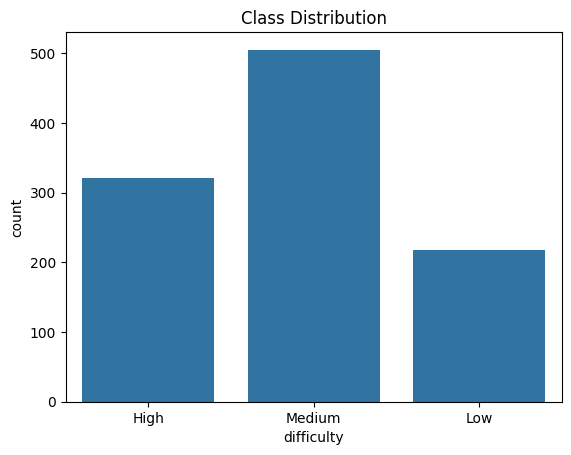

In [121]:
data['avg_score'] = data[['G1','G2','G3']].mean(axis=1)

def map_difficulty(score):
    if score >= 14:
        return 'Low'
    elif score >= 10:
        return 'Medium'
    else:
        return 'High'

data['difficulty'] = data['avg_score'].apply(map_difficulty)

data['difficulty'].value_counts()
sns.countplot(x='difficulty', data=data)
plt.title('Class Distribution')
plt.show()

## Bias and Fairness Check Across Gender

This analysis examines whether learning difficulty predictions are disproportionately distributed across gender groups.

The normalized cross-tabulation and stacked bar chart help verify that the model does not introduce unfair bias and treats demographic groups equitably.


difficulty      High       Low    Medium
sex                                     
F           0.297800  0.214890  0.487310
M           0.320088  0.200883  0.479029


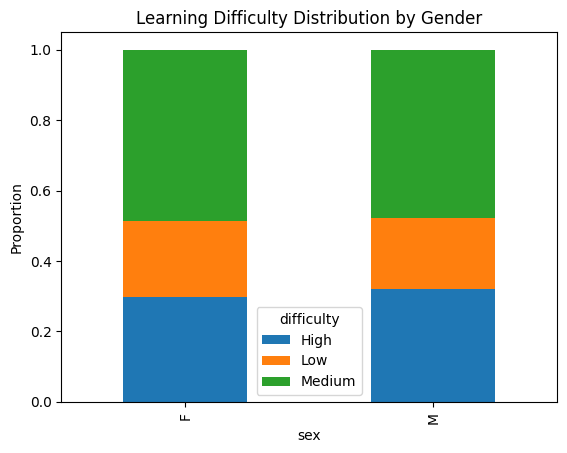

In [122]:
# Checking for Bias accross the genders
gender_bias = pd.crosstab(data['sex'], data['difficulty'], normalize='index')
print(gender_bias)

gender_bias.plot(kind='bar', stacked=True)
plt.title('Learning Difficulty Distribution by Gender')
plt.ylabel('Proportion')
plt.show()


## Feature Engineering

This step creates new behavioral indicators that better capture learning patterns:

- **Learning Pace**: Academic performance relative to study time
- **Attendance Ratio**: Regularity of class attendance
- **Academic Consistency**: Variability in exam scores

These engineered features enhance the model’s ability to understand student behavior beyond raw grades.


## Feature Selection and Dataset Preparation

Relevant academic and behavioral features are selected for model training.

The dataset is split into training and testing sets using stratified sampling to preserve class proportions.  
Feature scaling is applied using StandardScaler to ensure uniform feature contribution.


In [123]:
# Renamed the columns for clarity
data.rename(columns={'studytime':'study_time','absences':'absence_days'}, inplace=True)

# Behavioral features
data['learning_pace'] = data['avg_score'] / (data['study_time'] + 1)
data['attendance_ratio'] = 1 / (data['absence_days'] + 1)
data['academic_consistency'] = data[['G1','G2','G3']].std(axis=1)

features = [
    'study_time',
    'absence_days',
    'failures',
    'learning_pace',
    'attendance_ratio',
    'academic_consistency',
    'G1'
]


X = data[features]
y = data['difficulty']

X.head()

,study_time,absence_days,failures,learning_pace,attendance_ratio,academic_consistency,G1
0,2,4,0,2.444444,0.200000,6.350853,0
1,2,2,0,3.444444,0.333333,1.154701,9
2,2,6,0,4.111111,0.142857,0.577350,12
3,3,0,0,3.500000,1.000000,0.000000,14
4,2,0,0,4.111111,1.000000,1.154701,11


In [124]:
X = data.drop('difficulty', axis=1)

# To Identify categorical columns
categorical_cols = X.select_dtypes(include='object').columns

keep_cols = [
    'study_time','absence_days','failures',
    'learning_pace','attendance_ratio',
    'academic_consistency','G1'
]
X = data[keep_cols]


y = data['difficulty']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Model

A Logistic Regression model is trained as a baseline classifier.

It provides a simple, interpretable benchmark to evaluate how well linear decision boundaries can separate learning difficulty categories.


In [125]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

lr_preds = lr.predict(X_test_scaled)
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

        High       0.88      0.92      0.90        64
         Low       0.89      0.91      0.90        44
      Medium       0.91      0.87      0.89       101

    accuracy                           0.89       209
   macro avg       0.89      0.90      0.90       209
weighted avg       0.90      0.89      0.89       209



## Random Forest Model

A Random Forest classifier is trained to capture non-linear relationships between features.

This ensemble model improves robustness and predictive performance by combining multiple decision trees.


Based on performance metrics, the Random Forest model is selected as the final model due to its high accuracy and balanced classification performance across all difficulty levels.


In [126]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

        High       1.00      0.97      0.98        64
         Low       1.00      0.95      0.98        44
      Medium       0.96      1.00      0.98       101

    accuracy                           0.98       209
   macro avg       0.99      0.97      0.98       209
weighted avg       0.98      0.98      0.98       209



## Model Explainability Using Feature Importance

Feature importance scores from the Random Forest model are visualized to explain which factors most influence learning difficulty predictions.

This improves transparency and helps educators understand the key contributors to student learning challenges.


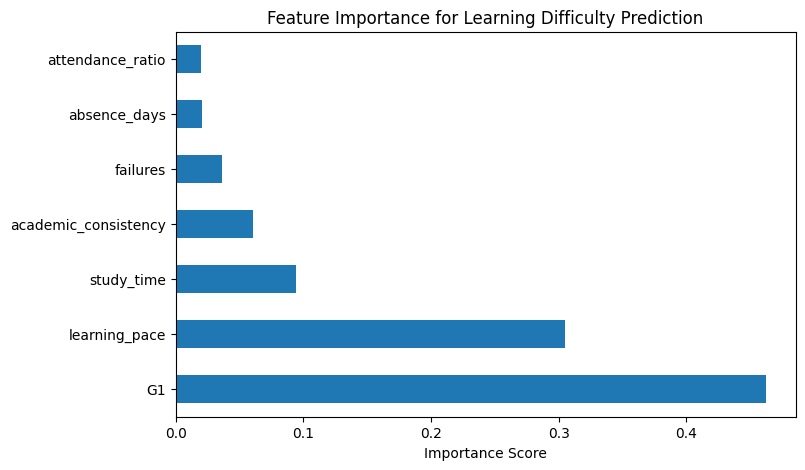

In [127]:
# Final selected model
final_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

final_model.fit(X_train, y_train)

# Feature Importance
importances = final_model.feature_importances_
# Here we have used the X_train.columns instead of the 'features' list to match the actual training data
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feature_importance.plot(kind='barh')
plt.title('Feature Importance for Learning Difficulty Prediction')
plt.xlabel('Importance Score')
plt.show()

## Learning Curve Analysis

Learning curves are plotted to evaluate how model performance changes with increasing training data.

This analysis helps detect overfitting or underfitting and confirms that the model generalizes well to unseen data.


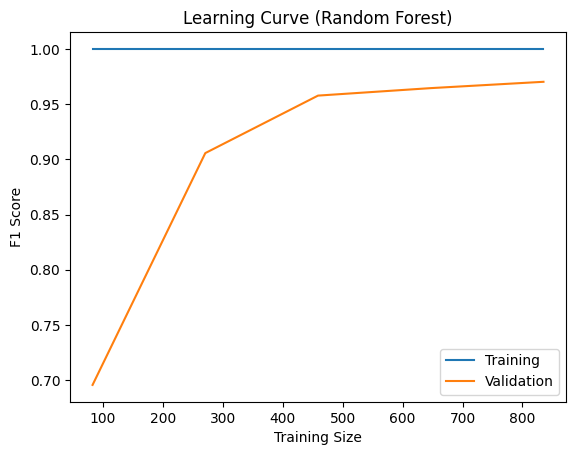

In [128]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    final_model,
    X,
    y,
    cv=5,
    scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Random Forest)')
plt.legend()
plt.show()


## Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of correct and incorrect predictions for each learning difficulty category.

This visualization helps assess classification errors and overall model reliability.


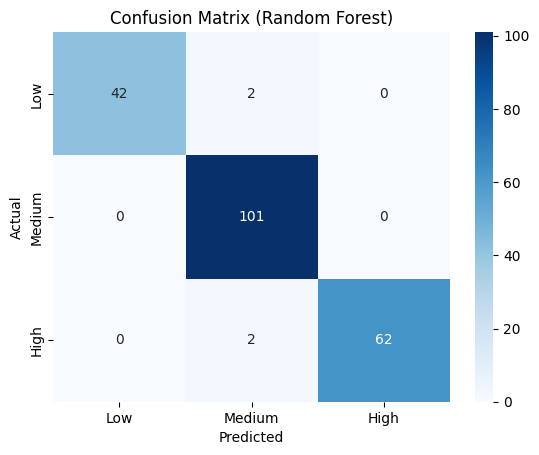

In [129]:
cm = confusion_matrix(y_test, rf_preds, labels=['Low','Medium','High'])
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Low','Medium','High'],
    yticklabels=['Low','Medium','High']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()


## Early Warning System for At-Risk Students

An early warning model is developed using only early academic and behavioral indicators.

This allows identification of students at risk of high learning difficulty before final assessments, enabling timely intervention and support.


In [130]:
# Early Warning Model
early_features = [
    'study_time',
    'absence_days',
    'failures',
    'learning_pace',
    'G1'
]

X_early = data[early_features]
y_early = data['difficulty']

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_early, y_early, test_size=0.2, stratify=y_early, random_state=42
)

early_model = LogisticRegression(max_iter=1000)
early_model.fit(X_train_e, y_train_e)

early_preds = early_model.predict(X_test_e)

print("Early Warning Model Performance:")
print(classification_report(y_test_e, early_preds))


Early Warning Model Performance:
              precision    recall  f1-score   support

        High       0.87      0.94      0.90        64
         Low       0.89      0.91      0.90        44
      Medium       0.92      0.86      0.89       101

    accuracy                           0.89       209
   macro avg       0.89      0.90      0.90       209
weighted avg       0.90      0.89      0.89       209



In [131]:
def recommend_strategy(difficulty):
    if difficulty == 'Low':
        return 'Advanced content + self-paced learning'
    elif difficulty == 'Medium':
        return 'Visual aids + weekly practice sessions'
    else:
        return 'Simplified content + one-on-one assisted learning'


## Learning Difficulty Prediction and Recommendation System

The final system predicts a student’s learning difficulty along with a confidence score.

Based on the predicted category, personalized learning strategies are recommended to support adaptive and inclusive education.


In [133]:
def predict_learning_difficulty(student_data):
    df = pd.DataFrame([student_data])
    df = df[features]

    prediction = final_model.predict(df)[0]
    confidence = np.max(final_model.predict_proba(df))

    return {
        "Predicted Difficulty": prediction,
        "Confidence (%)": float(round(confidence * 100, 2)),
        "Recommended Strategy": recommend_strategy(prediction)
    }



# Used a valid sample from the test set to ensure feature match
sample_student = X_test.iloc[0].to_dict()

predict_learning_difficulty(sample_student)

{'Predicted Difficulty': 'Low',
 'Confidence (%)': 100.0,
 'Recommended Strategy': 'Advanced content + self-paced learning'}

Project Members -
1. Tejas Attarde (ta2867)
2. Ehteshaam Siddiqui (es6663)
3. Yash Valsangkar (yhv2004)